In [ ]:
pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import wfdb
from dataclasses import dataclass
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score,KFold,RepeatedKFold,LeaveOneOut,train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

The data files are provided in WFDB format with two records per subject: one that contains the accelerometer, temperature, and EDA signals, and one that contains the arterial oxygen level (SpO2) and heart rate signals. Header files also contain information about the subject. There is one annotation file per subject that indicates the time locations and labels of the transition states. The subjectinfo.csv file also contains information about each subject.

https://physionet.org/content/noneeg/1.0.0/

https://wfdb.readthedocs.io/en/latest/


**The dataset consists of 7 stages for 20 subjects:**
1. First Relaxation: five minutes
2. Physical Stress: Stand for one minute, walk on a treadmill at one mile per hour for two minutes, then walk/jog on the treadmill at three miles per hour for two minutes.
3. Second Relaxation: five minutes.
4. 
  1. Mini-emotional stress*: 40 seconds (Note: This portion of the data, which was collected right before the cognitive stress task, is not explained in the paper.) During this 40 seconds, the “instructions” for the math portion of the cognitive stress (to count backwards by sevens, beginning with 2485, for three minutes) were read to the volunteer.
  2. Cognitive Stress: Count backwards by sevens, beginning with 2485, for three minutes. Next, perform the Stroop test for two minutes. The volunteer was alerted to errors by a buzzer. The Stroop test consisted of reading the names of colors written in a different color ink, then saying what color the ink was.
6. Third Relaxation: five minutes.
7. Emotional Stress: The volunteer was told he/she would be shown a five minute clip from a horror movie in one minute. After the minute of anticipation, a clip from a zombie apocalypse movie, The Horde was shown.
8. Fourth Relaxation: five minutes.

**The signals are recorded for around 35 minutes where the subject is subjected to stressful/non-stressful activites highlighted above.**

The variables in this dataset are:
- Acceleromter (ax,ay,az): Tracks the movement of the subject
- Temperature: Temperature of the room in degrees celsius
- Electrodermal Activity: A measure of stress measured in conductance units
- SpO2: The amount of oxygen in the blood as a percentage, a ratio of how much oxygen is in the blood compared to how much it can carry
- Heart Rate: The beats per minute of the subject

In [ ]:
"""
1. Each subject has 3 files AccTempEDA and SpO2 stored as a wfdb.io.record.Record object AND AccTempEDAAnn (the annotation) in
a struct/dataclass called Subject
2. This is simply for ease of access and streamlining processes
"""

@dataclass
class Subject:
  SpO2HR: wfdb.io.record.Record
  AccTempEDA: wfdb.io.record.Record
  AccTempEDAAnn: wfdb.io.annotation.Annotation
  signals: dict

In [ ]:
# import all subjects into one list
all_subjects = []
for i in tqdm(range(20)):
  all_subjects.append(Subject(wfdb.rdrecord(f'Subject{i+1}_SpO2HR', pn_dir='noneeg/1.0.0/'),
                              wfdb.rdrecord(f'Subject{i+1}_AccTempEDA', pn_dir='noneeg/1.0.0/'),
                              wfdb.rdann(f'Subject{i+1}_AccTempEDA', 'atr', pn_dir='noneeg/1.0.0/'),
                              {'Relax':[],'PhysicalStress':[],'EmotionalStress':[],'CognitiveStress':[]}))

100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


In [ ]:
# plot any subjects signal readings with annotations representing start/stop of stage
def subject_plot(i):
  wfdb.plot_wfdb(record = all_subjects[i].AccTempEDA,annotation=all_subjects[i].AccTempEDAAnn, time_units='minutes')
  wfdb.plot_wfdb(record = all_subjects[i].SpO2HR,annotation=all_subjects[i].AccTempEDAAnn, time_units='minutes')

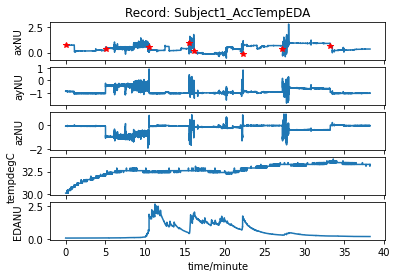

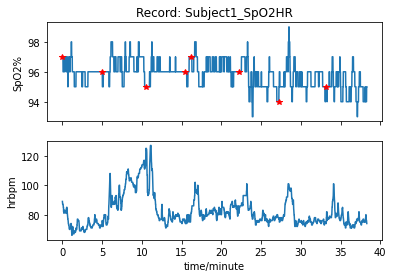

In [ ]:
subject_plot(0)

# Data Preprocessing

In this first code block we are putting everything into our 'signals' dict for each subject for ease of access.

In [ ]:
for i in tqdm(range(20)):
  sample = all_subjects[i].AccTempEDAAnn.__dict__['sample'] # sample name (for those with 8 per second)
  stages = all_subjects[i].AccTempEDAAnn.__dict__['aux_note'] #stage name
  signals = all_subjects[i].AccTempEDA.__dict__['p_signal'] #signal of those with 8 per sec
  hr_spo2 = all_subjects[i].SpO2HR.__dict__['p_signal'] #signal of one sample per sec
  sample_hr = np.floor(sample/8).astype(int) # change sample to be 1sample per sec instead of 8 per sec
  for j in range(len(stages)):
    if j!=7:
      all_subjects[i].signals[stages[j]].append({'ax':signals[sample[j]:sample[j+1],0],
                                                 'ay':signals[sample[j]:sample[j+1],1],
                                                 'az':signals[sample[j]:sample[j+1],2],
                                                 'temp':signals[sample[j]:sample[j+1],3],
                                                 'EDA':signals[sample[j]:sample[j+1],4],
                                                 'spo2':hr_spo2[sample_hr[j]:sample_hr[j+1],0],
                                                 'hr':hr_spo2[sample_hr[j]:sample_hr[j+1],1],
                                                 })
    else:
      all_subjects[i].signals[stages[j]].append({'ax':signals[sample[j]:,0],
                                                 'ay':signals[sample[j]:,1],
                                                 'az':signals[sample[j]:,2],
                                                 'temp':signals[sample[j]:,3],
                                                 'EDA':signals[sample[j]:,4],
                                                 'spo2':hr_spo2[sample_hr[j]:,0],
                                                 'hr':hr_spo2[sample_hr[j]:,1],
                                                 })

100%|██████████| 20/20 [00:00<00:00, 9734.95it/s]


This way we can access the signals for the ax reading of Subject 1 of the Physical Stress stage like so.

In [ ]:
all_subjects[0].signals['PhysicalStress'][0]['ax']

array([0.35000214, 0.31001205, 0.29004242, ..., 0.47002319, 0.44004334,
       0.31001205])

In [ ]:
var = ['ax','ay','az','EDA','temp','spo2','hr']
minimum_values_accEDA = {'Relax':2384,'PhysicalStress':2593,'EmotionalStress':320,'CognitiveStress':2769}
minimum_values_sp02hr = {'Relax':298,'PhysicalStress':298,'EmotionalStress':40,'CognitiveStress':298}
ite = [4,1,2,1] # number of times a stage is repeated (i.e. there are four relaxed stages)
types = ['Relax','PhysicalStress','EmotionalStress', 'CognitiveStress']

In this codeblock, we are making the signals for all subjects the same size. We first looked for the minimum values for the signals then we reshaped the rest to the minimum.

In [ ]:
for i in tqdm(range(20)): # loop over subjects
    for k in range(4): # identify which state you're in
      for w in range(ite[k]): # the number of times we will loop for each state
        for v in var: # loop over all variables
          if v in ['spo2','hr']: # if in spo2/hr then use the min values for those
              minimum = minimum_values_sp02hr[types[k]]
              all_subjects[i].signals[types[k]][w][v] = np.resize(all_subjects[i].signals[types[k]][w][v],new_shape=(minimum,))
          else: # else use the min values for the others
              minimum = minimum_values_accEDA[types[k]]
              all_subjects[i].signals[types[k]][w][v] = np.resize(all_subjects[i].signals[types[k]][w][v],new_shape=(minimum,))

100%|██████████| 20/20 [00:00<00:00, 642.43it/s]


In [ ]:
df = pd.DataFrame(columns=['vector','subject','stage','label'])
df = df.astype({'subject':int,'stage':str,'label':int})

## Feature Vector
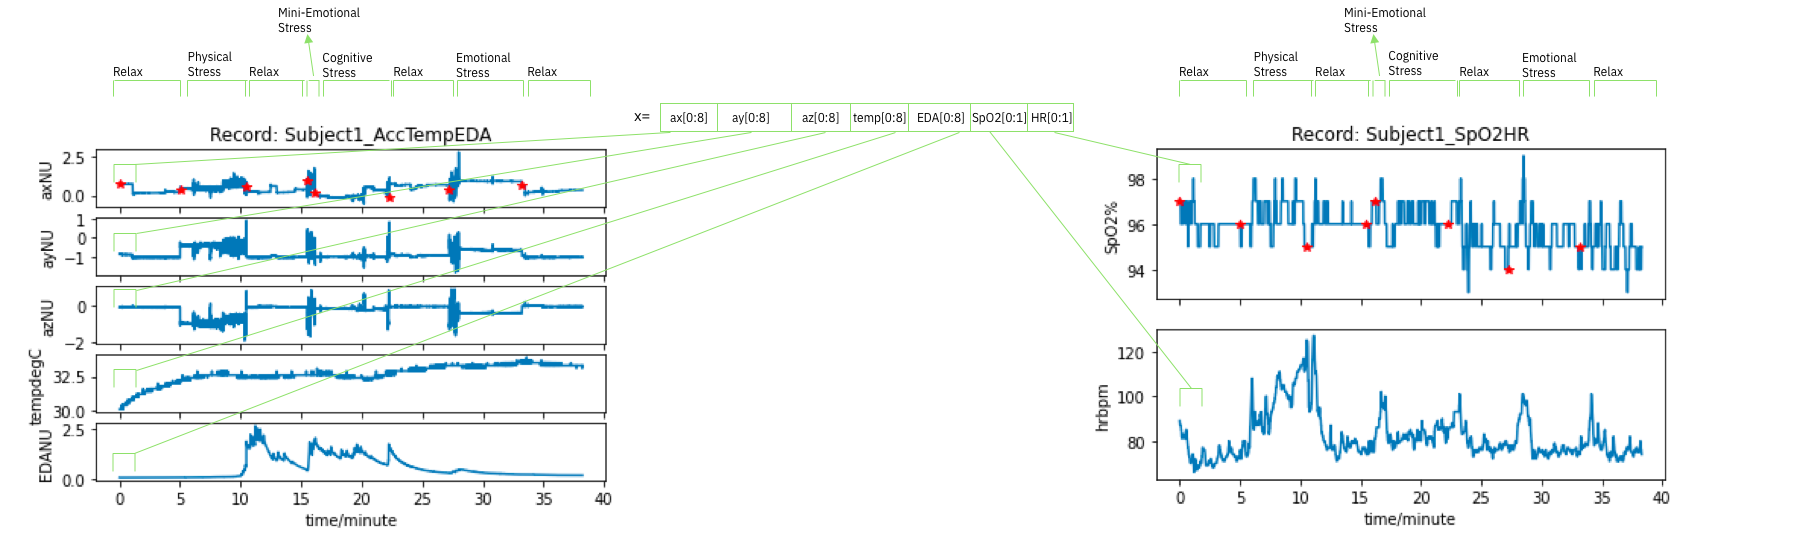

Here we are splitting the signal for each subject into multiple observations. We do this by taking 8 sample from ax, ay, ax, temp, and EDA and 1 sample from SpO2 and HR. We then concatenate all these into one single vector to represent one obervation. The dimension of the vector is 42, 8 values from ax, ay, az, temp, and EDA, which is 40 in total plus 1 observation from SpO2 and one from HR. This is done for all subjects and all stages. The value eta is tunable. For example, if we make eta=16 then we will take 16 observations from from ax, ay, ax, temp, and EDA and 2 sample from SpO2 and HR.

**Note: The first readings (i.e. ax, ay, az, temp, EDA) are 8 samples/s while the second readings (i.e. SpO2 and HR) are 1 sample/s therefore we always take 8 times the number of samples from the first reading compared to the second reading.**

In [ ]:
eta = 8
X = np.array([])
y = np.array([])
size1 = int(eta)
size2 = int(size1/8)
for person in tqdm(range(20)):#loop over subjects
  for k in range(4): 
    idx1 = int(minimum_values_accEDA[types[k]]/size1)
    idx2 = int(minimum_values_sp02hr[types[k]]/size2)
    for i in range(min(idx1,idx2)):
      for j in range(ite[k]): #types
        x = np.concatenate([all_subjects[person].signals[types[k]][j]['ax'][size1*i:(i+1)*size1],
                            all_subjects[person].signals[types[k]][j]['ay'][size1*i:(i+1)*size1],
                            all_subjects[person].signals[types[k]][j]['az'][size1*i:(i+1)*size1],
                            all_subjects[person].signals[types[k]][j]['EDA'][size1*i:(i+1)*size1],
                            all_subjects[person].signals[types[k]][j]['temp'][size1*i:(i+1)*size1],
                            all_subjects[person].signals[types[k]][j]['spo2'][size2*i:(i+1)*size2],
                            all_subjects[person].signals[types[k]][j]['hr'][size2*i:(i+1)*size2]])
        X = np.append(X,x)
        y = np.append(y,k)
        df = df.append({'vector': x,'subject':int(person+1),'stage':types[k],'label':k}, ignore_index=True)

100%|██████████| 20/20 [03:26<00:00, 10.34s/it]


In [ ]:
X = X.reshape(37360,42)

# Modeling

## Dimensionality Reduction

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=11)
pca.fit(scaled_X)

PCA(n_components=11)

We chose to take the first 11 principal components since they account for more than 99% of the variance in the data.

In [ ]:
explained_variance_ratios = pca.explained_variance_ratio_ # obtain explained variance ratios in descending order
cumulative_sum = np.cumsum(explained_variance_ratios) # compute the cumulative sum
cumulative_sum

array([0.2759892 , 0.53905049, 0.72470378, 0.84839492, 0.94131126,
       0.96528221, 0.98309351, 0.98641274, 0.98813135, 0.98970478,
       0.99100383])

In [ ]:
PC = pca.transform(scaled_X)

In [ ]:
PC.shape

(37360, 11)

## Classification

### Multilayer Perceptron

## Network Architecture
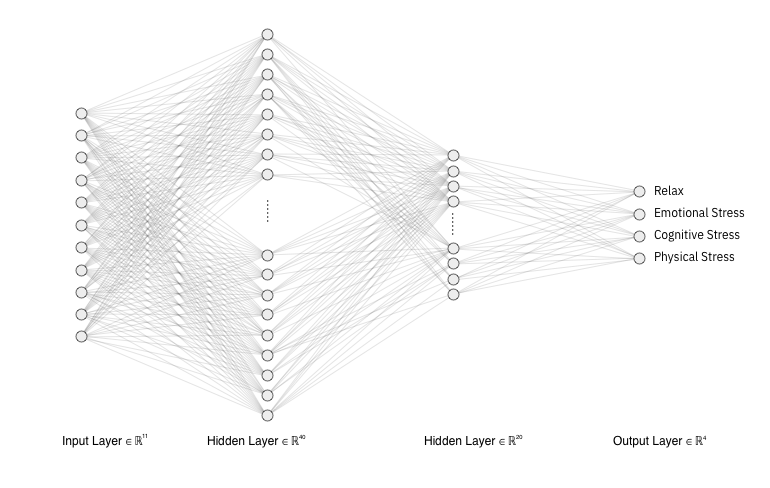

### Cross-validation Per Subject

In this codeblock, we train a model for each subject by splitting it into 80% train and 20% test. We then compute the accuracy for each subjects model. We apply this same procedure for kNN and Random Forest.

In [ ]:
LOO_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
LOO_accuracy_subject = LOO_accuracy_subject.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  PC_subject = PC[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
  mlp_subject = MLPClassifier(max_iter=500,hidden_layer_sizes=(40,20,),learning_rate_init=0.001,activation='relu')
  mlp_subject.fit(PC_subject_train, y_subject_train)
  y_hat_loo_subject = mlp_subject.predict(PC_subject_test)
  LOO_accuracy_subject = LOO_accuracy_subject.append({'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}, ignore_index=True)

100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


In [ ]:
LOO_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.00000
accuracy,0.981283,0.991979,0.994652,0.994652,0.986631,0.970588,0.994652,0.983957,0.983957,0.986631,0.983957,0.991979,0.997326,0.991979,0.991979,0.994652,0.989305,0.981283,0.989305,0.97861


In [ ]:
mean_acc = np.mean(LOO_accuracy_subject['accuracy'])
print('Mean accuracy: %.3f'%mean_acc)

Mean accuracy: 0.988


### Leave One Subject Out Validation

In this codeblock, we remove one subject from the data and train the model using the rest of the subjects. We then test the model on the subject we removed from the training data. We apply the same procedure for kNN and Random Forest.

In [ ]:
LOO_accuracy = pd.DataFrame(columns=['subject','accuracy'])
LOO_accuracy = LOO_accuracy.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  LOO_X_train = PC[df['subject']!=(i+1)]
  LOO_y_train = y[df['subject']!=(i+1)]
  LOO_X_test = PC[df['subject']==(i+1)]
  LOO_y_test = y[df['subject']==(i+1)]
  mlp_loo = MLPClassifier(max_iter=500,hidden_layer_sizes=(40,20,),learning_rate_init=0.001,activation='relu')
  mlp_loo.fit(LOO_X_train, LOO_y_train)
  y_hat_loo = mlp_loo.predict(LOO_X_test)
  LOO_accuracy = LOO_accuracy.append({'subject': i+1,'accuracy':accuracy_score(y_hat_loo,LOO_y_test)}, ignore_index=True)

100%|██████████| 20/20 [14:59<00:00, 44.97s/it]


In [ ]:
LOO_accuracy.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.00000,3.00000,4.0000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.0000,13.000000,14.000000,15.000000,16.000000,17.00000,18.000000,19.00000,20.000000
accuracy,0.385974,0.62955,0.85546,0.6697,0.562099,0.658994,0.711991,0.743576,0.779979,0.568522,0.771413,0.5803,0.729657,0.752677,0.792827,0.650964,0.40364,0.777302,0.31531,0.554069


In [ ]:
mean_acc = np.mean(LOO_accuracy['accuracy'])
print('Mean accuracy: %.3f'%mean_acc)

Mean accuracy: 0.645


## KNN

### Cross-validation Per Subject

In [ ]:
KNN_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
KNN_accuracy_subject = KNN_accuracy_subject.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  PC_subject = PC[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
  knn = KNeighborsClassifier(n_neighbors=50)
  knn.fit(PC_subject_train, y_subject_train)
  y_hat_loo_subject = knn.predict(PC_subject_test)
  KNN_accuracy_subject = KNN_accuracy_subject.append({'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}, ignore_index=True)

100%|██████████| 20/20 [00:00<00:00, 41.83it/s]


In [ ]:
KNN_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.00000,9.000000,10.000000,11.00000,12.000000,13.00000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.946524,0.946524,0.973262,0.914439,0.954545,0.882353,0.951872,0.94385,0.951872,0.933155,0.94385,0.930481,0.92246,0.949198,0.927807,0.938503,0.946524,0.930481,0.927807,0.919786


In [ ]:
mean_acc = np.mean(KNN_accuracy_subject['accuracy'])
print('Mean accuracy: %.3f'%mean_acc)

Mean accuracy: 0.937


##### Leave One Subject Out Validation

In [ ]:
KNN_LOO_accuracy = pd.DataFrame(columns=['subject','accuracy'])
KNN_LOO_accuracy = KNN_LOO_accuracy.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  LOO_X_train = PC[df['subject']!=(i+1)]
  LOO_y_train = y[df['subject']!=(i+1)]
  LOO_X_test = PC[df['subject']==(i+1)]
  LOO_y_test = y[df['subject']==(i+1)]
  knn = KNeighborsClassifier(n_neighbors=50)
  knn.fit(LOO_X_train, LOO_y_train)
  y_hat_loo = knn.predict(LOO_X_test)
  KNN_LOO_accuracy = KNN_LOO_accuracy.append({'subject': i+1,'accuracy':accuracy_score(y_hat_loo,LOO_y_test)}, ignore_index=True)

100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


In [ ]:
KNN_LOO_accuracy.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.00000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.622056,0.721092,0.913812,0.81531,0.752677,0.786403,0.612955,0.801927,0.789615,0.798715,0.796574,0.607066,0.669165,0.802463,0.788544,0.589936,0.425589,0.807281,0.571199,0.650964


In [ ]:
mean_acc = np.mean(KNN_LOO_accuracy['accuracy'])
print('Mean accuracy: %.3f'%mean_acc)

Mean accuracy: 0.716


## Random Forests

### Cross-validation Per Subject

In [ ]:
RF_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
RF_accuracy_subject = RF_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  PC_subject = PC[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
  #Create a Gaussian Classifier
  clf=RandomForestClassifier(n_estimators=100)
  clf.fit(PC_subject_train, y_subject_train)
  y_hat_loo_subject = clf.predict(PC_subject_test)
  RF_accuracy_subject = RF_accuracy_subject.append({'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}, ignore_index=True)

100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


In [ ]:
RF_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.00000,19.000000,20.000000
accuracy,0.986631,0.981283,0.997326,0.991979,0.989305,0.970588,0.994652,0.973262,0.986631,0.989305,0.986631,0.983957,0.997326,0.983957,0.994652,0.989305,0.981283,0.97861,0.983957,0.975936


In [ ]:
mean_acc = np.mean(RF_accuracy_subject['accuracy'])
print('Mean accuracy: %.3f'%mean_acc)

Mean accuracy: 0.986


#### Leave One Subject Out Validation

In [ ]:
RF_all_subjects = pd.DataFrame(columns=['subject','accuracy'])
RF_all_subjects = RF_all_subjects.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  LOO_X_train = PC[df['subject']!=(i+1)]
  LOO_y_train = y[df['subject']!=(i+1)]
  LOO_X_test = PC[df['subject']==(i+1)]
  LOO_y_test = y[df['subject']==(i+1)]
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(LOO_X_train, LOO_y_train)
  y_hat_loo = clf.predict(LOO_X_test)
  RF_all_subjects = RF_all_subjects.append({'subject': i+1,'accuracy':accuracy_score(y_hat_loo,LOO_y_test)}, ignore_index=True)

100%|██████████| 20/20 [05:05<00:00, 15.26s/it]


In [ ]:
RF_all_subjects.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.00000,4.00000,5.000000,6.000000,7.000000,8.000000,9.000000,10.00000,11.000000,12.00000,13.000000,14.000000,15.000000,16.000000,17.000000,18.00000,19.000000,20.000000
accuracy,0.723769,0.694861,0.91863,0.85439,0.752677,0.788009,0.920236,0.825482,0.802463,0.87045,0.808351,0.59636,0.858137,0.789079,0.793897,0.699679,0.482334,0.82334,0.752141,0.640792


In [ ]:
mean_acc = np.mean(RF_all_subjects['accuracy'])
print('Mean accuracy: %.3f'%mean_acc)

Mean accuracy: 0.770
